Project: /overview/_project.yaml
Book: /overview/_book.yaml

<link rel="stylesheet" href="/site-assets/css/style.css">

<!-- DO NOT EDIT! Automatically generated file. -->


{% comment %}
The source of truth file can be found [here]: http://google3/zz
{% endcomment %}

<div itemscope itemtype="http://developers.google.com/ReferenceObject">
<meta itemprop="name" content="勾配と自動微分の基礎" />
<meta itemprop="path" content="Guide & Tutorials" />
<meta itemprop="property" content="tf.GradientTape"/>
<meta itemprop="property" content="tf.Variable"/>
<meta itemprop="property" content="tf.constant"/>
<meta itemprop="property" content="tf.image.adjust_contrast"/>
<meta itemprop="property" content="tf.keras.layers.Dense"/>
<meta itemprop="property" content="tf.linspace"/>
<meta itemprop="property" content="tf.math.reduce_mean"/>
<meta itemprop="property" content="tf.math.reduce_sum"/>
<meta itemprop="property" content="tf.math.sigmoid"/>
<meta itemprop="property" content="tf.math.sin"/>
<meta itemprop="property" content="tf.math.softplus"/>
<meta itemprop="property" content="tf.random.normal"/>
<meta itemprop="property" content="tf.zeros"/>
</div>

# 勾配と自動微分の基礎

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/guide/autodiff">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/autodiff.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/autodiff.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/autodiff.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 自動微分と勾配

[自動微分](https://en.wikipedia.org/wiki/Automatic_differentiation)は、ニューラルネットワークをトレーニングする[バックプロパゲーション](https://en.wikipedia.org/wiki/Backpropagation)などの機械学習アルゴリズムの実装に有用です。

このガイドでは、特に Eager execution において、TensorFlow を使用して勾配を計算する方法について説明します。

## セットアップ

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

2022-12-14 20:39:02.123526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:39:02.123617: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:39:02.123626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## 勾配を計算する

TensorFlow は、自動的に微分するために、*フォワード*パス中にどのような演算がどの順序で行われたかを覚えておく必要があります。その後、TensorFlow は*逆方向パス*中にこの演算のリストを逆順に走査し、勾配を計算します。

## 勾配テープ

TensorFlow には、一部の入力、通常は<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>に関する計算の勾配を計算する、自動微分のための [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) API があります。TensorFlow は、<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a>のコンテキスト内で実行される関連の演算を「テープ」に「記録」します。その後、TensorFlow はそのテープを使い、[リバースモード微分](https://en.wikipedia.org/wiki/Automatic_differentiation)を使用して「記録」された計算の勾配を計算します。

簡単な例を示します。

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as tape:
  y = x**2

いくつかの演算を記録してから、<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient"><code>GradientTape.gradient(target, sources)</code></a>を使用して、いくつかのソース（多くの場合はモデルの変数）に対するいくつかのターゲット（多くの場合は損失）の勾配を計算します。

In [4]:
# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

上記の例ではスカラーを使用していますが、どのテンソルでも<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a>は簡単に機能します。

In [5]:
w = tf.Variable(tf.random.normal((3, 2)), name='w')
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
x = [[1., 2., 3.]]

with tf.GradientTape(persistent=True) as tape:
  y = x @ w + b
  loss = tf.reduce_mean(y**2)

両方の変数に関する `loss` 勾配を取得するには、両方をソースとして `gradient` メソッドに渡すことができます。テープはソースがどのように渡されるかについては柔軟であり、リストまたはディクショナリのネストされた組み合わせを受け入れ、同じ方法で構造化された勾配を返します（<a href="https://www.tensorflow.org/api_docs/python/tf/nest"><code>tf.nest</code></a> を参照）。

In [6]:
[dl_dw, dl_db] = tape.gradient(loss, [w, b])

各ソースに関する勾配には、ソースの形状があります。

In [7]:
print(w.shape)
print(dl_dw.shape)

(3, 2)
(3, 2)


下記もまた勾配計算ですが、この例では変数のディクショナリを渡します。

In [8]:
my_vars = {
    'w': w,
    'b': b
}

grad = tape.gradient(loss, my_vars)
grad['b']

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-7.4161186, -5.151042 ], dtype=float32)>

## モデルに関する勾配

[チェックポイント](checkpoint.ipynb)と[エクスポート](saved_model.ipynb)をするために、`tf.Variables`を<a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a>あるいはそのサブクラスの 1 つ（<a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer"><code>layers.Layer</code></a>、<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model"><code>keras.Model</code></a>）に収集するのは一般的です。

ほとんどの場合は、モデルのトレーニング可能な変数に対する勾配を計算する必要があります。<a href="https://www.tensorflow.org/api_docs/python/tf/Module"><code>tf.Module</code></a>のすべてのサブクラスはそれらの変数を<a href="https://www.tensorflow.org/api_docs/python/tf/Module#trainable_variables"><code>Module.trainable_variables</code></a>プロパティに集約するため、それらの勾配を数行のコードで計算することができます。 

In [9]:
layer = tf.keras.layers.Dense(2, activation='relu')
x = tf.constant([[1., 2., 3.]])

with tf.GradientTape() as tape:
  # Forward pass
  y = layer(x)
  loss = tf.reduce_mean(y**2)

# Calculate gradients with respect to every trainable variable
grad = tape.gradient(loss, layer.trainable_variables)

In [10]:
for var, g in zip(layer.trainable_variables, grad):
  print(f'{var.name}, shape: {g.shape}')

dense/kernel:0, shape: (3, 2)
dense/bias:0, shape: (2,)


<a id="watches"></a>

## テープの監視対象を制御する

デフォルトの動作では、トレーニング可能な<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>にアクセスした後、全ての演算を記録します。その理由は次の通りです。

- 逆方向パスの勾配を計算するために、テープはフォワードパス中のどの演算を記録するか、知っておく必要があります。
- テープは中間出力への参照を保持するため、不要な演算を記録する必要はありません。
- 最も一般的な使用例として、モデルのトレーニング可能なすべての変数に対する損失の勾配の計算があります。

たとえば、次の例ではデフォルトで <a href="https://www.tensorflow.org/api_docs/python/tf/Tensor"><code>tf.Tensor</code></a> が「監視」されておらず、<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> はトレーニング対象外であるため、勾配の計算ができません。

In [11]:
# A trainable variable
x0 = tf.Variable(3.0, name='x0')
# Not trainable
x1 = tf.Variable(3.0, name='x1', trainable=False)
# Not a Variable: A variable + tensor returns a tensor.
x2 = tf.Variable(2.0, name='x2') + 1.0
# Not a variable
x3 = tf.constant(3.0, name='x3')

with tf.GradientTape() as tape:
  y = (x0**2) + (x1**2) + (x2**2)

grad = tape.gradient(y, [x0, x1, x2, x3])

for g in grad:
  print(g)

tf.Tensor(6.0, shape=(), dtype=float32)
None
None
None


<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape#watched_variables"><code>GradientTape.watched_variables</code></a>メソッドを使用すると、テープが監視している変数を一覧表示できます。

In [12]:
[var.name for var in tape.watched_variables()]

['x0:0']

<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a>は、ユーザーが監視対象や非監視対象を制御できるフックを提供します。

<a href="https://www.tensorflow.org/api_docs/python/tf/Tensor"><code>tf.Tensor</code></a>に関する勾配を記録するには、<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape#watch"><code>GradientTape.watch(x)</code></a>を呼び出す必要があります。

In [13]:
x = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(x)
  y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
print(dy_dx.numpy())

6.0


逆に、すべての`tf.Variables`を監視するデフォルトの動作を無効にするには、勾配テープの作成時に`watch_accessed_variables=False`を設定します。この計算には 2 つの変数を使用しますが、1 つの変数の勾配のみに接続します。

In [14]:
x0 = tf.Variable(0.0)
x1 = tf.Variable(10.0)

with tf.GradientTape(watch_accessed_variables=False) as tape:
  tape.watch(x1)
  y0 = tf.math.sin(x0)
  y1 = tf.nn.softplus(x1)
  y = y0 + y1
  ys = tf.reduce_sum(y)

<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape#watch"><code>GradientTape.watch</code></a>は`x0`で呼び出されなかったため、それに関する勾配は計算されません。

In [15]:
# dys/dx1 = exp(x1) / (1 + exp(x1)) = sigmoid(x1)
grad = tape.gradient(ys, {'x0': x0, 'x1': x1})

print('dy/dx0:', grad['x0'])
print('dy/dx1:', grad['x1'].numpy())

dy/dx0: None
dy/dx1: 0.9999546


## 中間結果

<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape"><code>tf.GradientTape</code></a>コンテキスト中で計算された中間の値に対する出力の勾配をリクエストすることもできます。

In [16]:
x = tf.constant(3.0)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = x * x
  z = y * y

# Use the tape to compute the gradient of z with respect to the
# intermediate value y.
# dz_dy = 2 * y and y = x ** 2 = 9
print(tape.gradient(z, y).numpy())

18.0


デフォルトでは、ある `GradientTape` に保持されたリソースは、<a href="https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient"><code>GradientTape.gradient</code></a> メソッドが呼び出されるとすぐに解放されます。同じ計算で複数の勾配を計算する場合は、`persistent=True` を指定した勾配テープを作成します。こうすると、テープオブジェクトのガベージコレクションを実行するときにリソースが解放されるため、`gradient` メソッドを何度も呼び出すことができます。例を示します。

In [17]:
x = tf.constant([1, 3.0])
with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

print(tape.gradient(z, x).numpy())  # [4.0, 108.0] (4 * x**3 at x = [1.0, 3.0])
print(tape.gradient(y, x).numpy())  # [2.0, 6.0] (2 * x at x = [1.0, 3.0])

[  4. 108.]
[2. 6.]


In [18]:
del tape   # Drop the reference to the tape

## パフォーマンスに関する注記

- 勾配テープコンテキスト内の演算の実行に伴う、少量のオーバーヘッドがあります。ほとんどの Eager Execution では、これは目立ったコストにはなりませんが、それでもテープコンテキストは必要な領域のみで使用すべきです。

- 勾配テープは、メモリを使用して入力と出力を含む中間結果を格納し、逆方向パス中に使用します。

    `ReLU`などの一部の演算は、中間結果を保持する必要がないため、効率を上げるためにフォワードパス中に削除されます。ただし、テープに`persistent=True`を使用している場合は*何も破棄されない*ため、ピーク時のメモリ使用量が高くなります。

## 非スカラーのターゲットの勾配

勾配は基本的にスカラーの演算です。

In [19]:
x = tf.Variable(2.0)
with tf.GradientTape(persistent=True) as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient(y0, x).numpy())
print(tape.gradient(y1, x).numpy())

4.0
-0.25


したがって、複数のターゲットの勾配を求める場合、各ソースの結果は次のようになります。

- ターゲットの合計の勾配、あるいは
- 各ターゲットの勾配の合計

In [20]:
x = tf.Variable(2.0)
with tf.GradientTape() as tape:
  y0 = x**2
  y1 = 1 / x

print(tape.gradient({'y0': y0, 'y1': y1}, x).numpy())

3.75


同様に、ターゲットがスカラーでない場合は、合計の勾配が計算されます。

In [21]:
x = tf.Variable(2.)

with tf.GradientTape() as tape:
  y = x * [3., 4.]

print(tape.gradient(y, x).numpy())

7.0


これにより、損失を集めた合計の勾配、または要素ごとの損失計算の合計の勾配の取得が容易になります。

アイテムごとに個別の勾配が必要な場合は、[Jacobians（ヤコビアン）](advanced_autodiff.ipynb#jacobians)をご覧ください。

場合によっては、ヤコビアンをスキップすることができます。要素についての計算の場合、各要素は独立しているため、合計の勾配は入力要素に対する各要素の導関数を与えます。

In [22]:
x = tf.linspace(-10.0, 10.0, 200+1)

with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

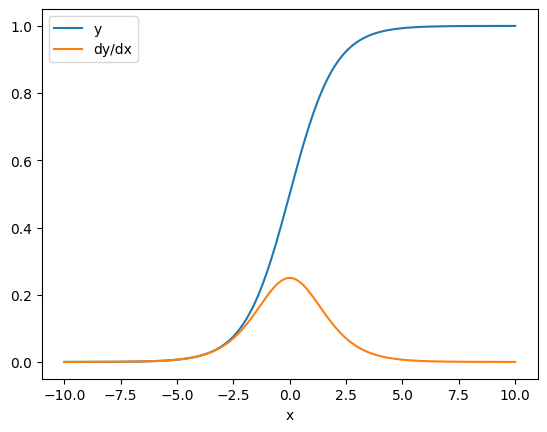

In [23]:
plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

## 制御フロー

勾配テープは実行時に演算を記録するため、Python 制御フローは自然に処理されます（`if` 文や `while` 文など）。

ここでは、`if`の各ブランチで異なる変数が使用されています。勾配は使用された変数にのみ接続します。

In [24]:
x = tf.constant(1.0)

v0 = tf.Variable(2.0)
v1 = tf.Variable(2.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  if x > 0.0:
    result = v0
  else:
    result = v1**2 

dv0, dv1 = tape.gradient(result, [v0, v1])

print(dv0)
print(dv1)

tf.Tensor(1.0, shape=(), dtype=float32)
None


制御文自体は微分不可能なため、勾配ベースのオプティマイザから見えないということに注意してください。

上記の例の`x`の値次第で、テープは`result = v0`または`result = v1**2`を記録します。`x`に対する勾配は常に`None`です。

In [25]:
dx = tape.gradient(result, x)

print(dx)

None


## `gradient`が`None`を返すケース

ターゲットがソースに接続されていない場合、勾配は`None`になります。

In [26]:
x = tf.Variable(2.)
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y * y
print(tape.gradient(z, x))

None


ここでは明らかに`z`が`x`に接続されていませんが、これほど明白ではないにしても勾配が非接続になりうる場合がいくつかあります。

### 1. 変数をテンソルに置換した場合

[「テープの監視対象を制御する」](#watches)のセクションで説明したようにテープは自動的に<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>を監視しますが、<a href="https://www.tensorflow.org/api_docs/python/tf/Tensor"><code>tf.Tensor</code></a>は監視しません。

よくあるエラーの 1 つは、<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>を更新するために<a href="https://www.tensorflow.org/api_docs/python/tf/Variable#assign"><code>Variable.assign</code></a>を使用する代わりに、<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a>を<a href="https://www.tensorflow.org/api_docs/python/tf/Tensor"><code>tf.Tensor</code></a>で置き換えてしまうことです。例を示します。

In [27]:
x = tf.Variable(2.0)

for epoch in range(2):
  with tf.GradientTape() as tape:
    y = x+1

  print(type(x).__name__, ":", tape.gradient(y, x))
  x = x + 1   # This should be `x.assign_add(1)`

ResourceVariable : tf.Tensor(1.0, shape=(), dtype=float32)
EagerTensor : None


### 2. TensorFlowの外で計算をした

計算が TensorFlow から出てしまうと、テープは勾配パスを記録することができません。例を示します。

In [28]:
x = tf.Variable([[1.0, 2.0],
                 [3.0, 4.0]], dtype=tf.float32)

with tf.GradientTape() as tape:
  x2 = x**2

  # This step is calculated with NumPy
  y = np.mean(x2, axis=0)

  # Like most ops, reduce_mean will cast the NumPy array to a constant tensor
  # using `tf.convert_to_tensor`.
  y = tf.reduce_mean(y, axis=0)

print(tape.gradient(y, x))

None


### 3. 整数または文字列を使用して勾配を取得した

整数と文字列は微分不可能です。計算パスがこれらのデータ型を使用する場合は、勾配を取得できません。

文字列は微分不可能だと知っていても、`dtype`を指定していない場合に、うっかり`int`定数や変数を作成してしまう可能性があります。

In [29]:
x = tf.constant(10)

with tf.GradientTape() as g:
  g.watch(x)
  y = x * x

print(g.gradient(y, x))

None


TensorFlow は、型間で自動的にキャストしないため、実際には、欠損した勾配の代わりに型のエラーが表示されることがよくあります。

### 4. ステートフルオブジェクトを使用して勾配を取得した

状態は勾配を停止します。ステートフルオブジェクトから読み取る場合、テープはその時点の状態のみを確認し、その状態に至るまでの履歴を確認できません。

<a href="https://www.tensorflow.org/api_docs/python/tf/Tensor"><code>tf.Tensor</code></a> は不変で、一旦作成したテンソルは変更できません。*値*はありますが、*状態*はありません。これまでに説明したすべての演算もステートレスで、<a href="https://www.tensorflow.org/api_docs/python/tf/linalg/matmul"><code>tf.matmul</code></a> の出力はその入力のみに依存します。

<a href="https://www.tensorflow.org/api_docs/python/tf/Variable"><code>tf.Variable</code></a> tf.Variable には内部状態とその値があるため、変数を使用するとその状態が読み取られます。変数に関する勾配を計算するのは通例ですが、変数の状態によって勾配の計算をさかのぼって行うことはできません。次に例を示します。

In [30]:
x0 = tf.Variable(3.0)
x1 = tf.Variable(0.0)

with tf.GradientTape() as tape:
  # Update x1 = x1 + x0.
  x1.assign_add(x0)
  # The tape starts recording from x1.
  y = x1**2   # y = (x1 + x0)**2

# This doesn't work.
print(tape.gradient(y, x0))   #dy/dx0 = 2*(x1 + x0)

None


同様に、<a href="https://www.tensorflow.org/api_docs/python/tf/data/Dataset"><code>tf.data.Dataset</code></a> イテレータと <a href="https://www.tensorflow.org/api_docs/python/tf/queue"><code>tf.queue</code></a> はステートフルであるため、それらを通過するテンソルのすべての勾配を停止します。

## 勾配が登録されていない

一部の<a href="https://www.tensorflow.org/api_docs/python/tf/Operation"><code>tf.Operation</code></a>は**微分不可能として登録されているため**、`None`を返します。その他は**勾配の登録がされていません**。

[tf.raw_ops](https://www.tensorflow.org/api_docs/python/tf/raw_ops) のページには、勾配を登録する低レベルの演算が示されています。

勾配が登録されていない浮動小数点演算を介して勾配を取得しようとすると、テープは暗黙的に`None`を返す代わりにエラーをスローします。これにより、何かが間違っていることが分かります。

たとえば、<a href="https://www.tensorflow.org/api_docs/python/tf/image/adjust_contrast"><code>tf.image.adjust_contrast</code></a> 関数は、<a href="https://www.tensorflow.org/api_docs/python/tf/raw_ops/AdjustContrastv2"><code>raw_ops.AdjustContrastv2</code></a> をラップしており、勾配があっても、その勾配は実装されていません。

In [31]:
image = tf.Variable([[[0.5, 0.0, 0.0]]])
delta = tf.Variable(0.1)

with tf.GradientTape() as tape:
  new_image = tf.image.adjust_contrast(image, delta)

try:
  print(tape.gradient(new_image, [image, delta]))
  assert False   # This should not happen.
except LookupError as e:
  print(f'{type(e).__name__}: {e}')


LookupError: gradient registry has no entry for: AdjustContrastv2


この演算で微分する必要がある場合は、勾配を実装して登録する（<a href="https://www.tensorflow.org/api_docs/python/tf/RegisterGradient"><code>tf.RegisterGradient</code></a> を使用）か、ほかの演算を使用して関数を再実装する必要があります。

## None の代わりにゼロを取得する

場合によっては、接続されていない勾配で`None`ではなく 0（ゼロ）を取得すると便利です。`unconnected_gradients`引数を使用すると、接続されていない勾配がある場合に何を返すかを決めることができます。

In [32]:
x = tf.Variable([2., 2.])
y = tf.Variable(3.)

with tf.GradientTape() as tape:
  z = y**2
print(tape.gradient(z, x, unconnected_gradients=tf.UnconnectedGradients.ZERO))

tf.Tensor([0. 0.], shape=(2,), dtype=float32)
